In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import time

In [2]:
import gpflow as gpf

# import gpflow.multioutput.kernels as mk
# import gpflow.multioutput.features as mf

MAXITER = gpf.test_util.notebook_niter(15000)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Load Data

In [4]:
N = 60000

In [5]:
# (train_data, train_labels), (test_data, test_labels) = FashionMNIST()

train_data = np.load('../../datasets/export/fashion_mnist/numpy/train_data_fashion_mnist.npy').astype('uint8')
test_data = np.load('../../datasets/export/fashion_mnist/numpy/test_data_fashion_mnist.npy').astype('uint8')
train_labels = np.load('../../datasets/export/fashion_mnist/numpy/train_targets_fashion_mnist.npy').astype('uint8')
test_labels = np.load('../../datasets/export/fashion_mnist/numpy/test_targets_fashion_mnist.npy').astype('uint8')

# Convert one-hot to integers
train_labels = np.argmax(train_labels, axis=1)[:N]
test_labels = np.argmax(test_labels, axis=1)

D = train_data[0].reshape(-1).shape[0]

# Flatten the images
train_data = train_data.reshape(-1, D)[:N]
test_data = test_data.reshape(-1, D)

In [6]:
def threshold_binarize(data, threshold):
    data_bin = np.where(data>threshold, 1, 0).astype('uint8')
    return data_bin

In [7]:
# fashion mnist has values between 0 and 255
threshold = 10

train_data_bin = threshold_binarize(train_data, threshold).astype('float64')
test_data_bin = threshold_binarize(test_data, threshold).astype('float64')

In [8]:
# like one-hot encoding with 0 corresponding to -1
label_binarizer = LabelBinarizer(pos_label=1, neg_label=-1)
train_labels_bin = label_binarizer.fit_transform(train_labels).astype('float64')
test_labels_bin = label_binarizer.fit_transform(test_labels).astype('float64')

In [12]:
# custom_config = gpf.settings.get_settings()

In [14]:
# custom_config.float_type = 'float32'

## Debug

In [64]:
# create multioutput kernel
kernel = mk.SharedIndependentMok(gpf.kernels.RBF(784), output_dimensionality=10) # maybe add the white noise kernel 
# initialisation of inducing input locations (M random points from the training inputs)
Z = train_data_bin[:M,...].copy() 
# create multioutput features from Z
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(Z)) 

## Own Kernel

In [9]:
import tensorflow as tf

class OPUKernel(gpf.kernels.Kernel):
    def __init__(self, input_dim):
        super().__init__(input_dim=1, active_dims=None)
        self.poly_kernel = gpf.kernels.Polynomial(input_dim, degree=2.0, variance=1.0, offset=0, active_dims=None, ARD=False)
        self.poly_kernel.variance.trainable = False
        self.poly_kernel.offset.trainable = False
        self.variance = gpf.Param(1.0, transform=gpf.transforms.positive)
        self.dummy = gpf.Param(0.0, transform=gpf.transforms.positive)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
            
        print('X', X.shape)
        print('X2', X2.shape)
        
        self.poly_kernel.offset = self.dummy
        kernel = self.poly_kernel.K(X, X2=X2)
        
        print('Kernel', kernel.shape)
        
        norm_x_sq = tf.square(tf.norm(X, ord='euclidean', axis=1, keepdims=True) + self.dummy)
        norm_y_sq = tf.square(tf.norm(X2, ord='euclidean', axis=1, keepdims=True) + self.dummy)
        
        print('Norm x', norm_x_sq.shape)
        print('Norm y', tf.transpose(norm_y_sq).shape)
        
        kernel += tf.matmul(norm_x_sq, tf.transpose(norm_y_sq))
        
        print(kernel.shape)
        
        return self.variance * kernel

    def Kdiag(self, X):
        self.poly_kernel.offset = self.dummy
        kernel = self.poly_kernel.Kdiag(X)
        kernel += tf.square(tf.reduce_sum(tf.square(X), -1) + self.dummy)
        
        return self.variance * kernel

## SGVP

In [10]:
M = 500

In [11]:
from sklearn.cluster import MiniBatchKMeans
# manually fit on batches
kmeans = MiniBatchKMeans(n_clusters=M, random_state=0, batch_size=1000)
kmeans.fit(train_data_bin)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=500, n_init=3, random_state=0, reassignment_ratio=0.01,
        tol=0.0, verbose=0)

In [16]:
Z =  kmeans.cluster_centers_

In [96]:
Z.shape

(500, 784)

In [10]:
M = 500
Z = train_data_bin[:M]

In [11]:
gpf.reset_default_graph_and_session()

In [57]:
kernel = gpf.kernels.RBF(784, ARD=False)

In [12]:
kernel = OPUKernel(784)

In [12]:
kernel = gpf.kernels.Polynomial(784, ARD=False, degree=2)

In [13]:
kernel.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
Polynomial/offset,Parameter,None,+ve,True,(),True,1.0
Polynomial/variance,Parameter,None,+ve,True,(),True,1.0


In [13]:
# create SVGP model as usual and optimise

m = gpf.models.SVGP(
        train_data_bin,
        train_labels_bin,
        kernel,
        gpf.likelihoods.Gaussian(),
        Z.copy(),
        minibatch_size=60000,
        whiten=True
) 

# opt = gpf.train.ScipyOptimizer()
# opt.minimize(m, disp=True, maxiter=MAXITER)

X (500, 784)
X2 (500, 784)
Kernel (500, 500)
Norm x (500, 1)
Norm y (1, 500)
(500, 500)
X (500, 784)
X2 <unknown>
Kernel (500, ?)
Norm x (500, 1)
Norm y <unknown>
(500, ?)


In [126]:
minibatch_size = 100
ground_truth = m.compute_log_likelihood()
m.X.set_batch_size(minibatch_size)
m.Y.set_batch_size(minibatch_size)

In [81]:
evals = [m.compute_log_likelihood() for _ in range(100)]

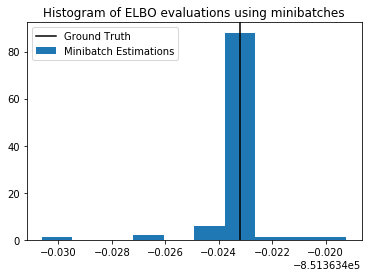

In [82]:
plt.hist(evals, label='Minibatch Estimations')
plt.axvline(ground_truth, c='k', label='Ground Truth')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches');

In [76]:
m

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),True,"(244, 784)",True,"[[0.0, 0.0, -2.726637349854944e-140, -2.686843..."
SVGP/kern/lengthscales,Parameter,None,+ve,True,(),True,0.9999974716903142
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0065795331188931e-06
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,0.9999886907426154
SVGP/q_mu,Parameter,None,(none),True,"(244, 10)",True,"[[-9.303859171894316e-16, -9.303859171894316e-..."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(10, 244, 244)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [14]:
class Logger(gpf.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)
            
            print('Iteration {}'.format(ctx.iteration), '-Likelihood: {}'.format(likelihood))

In [15]:
minibatch_size = 500
m.X.set_batch_size(minibatch_size)
m.Y.set_batch_size(minibatch_size)

# We turn of training for inducing point locations
m.feature.trainable = True

def run_adam(model, iterations):
    """
    Utility function running the Adam Optimiser interleaved with a `Logger` action.
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    adam = gpf.train.AdamOptimizer(learning_rate=0.001).make_optimize_action(model)
    # adam = gpf.train.ScipyOptimizer(method='L-BFGS-B').minimize(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpf.actions.Loop(actions, stop=iterations)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

In [16]:
gpf.train.ScipyOptimizer().minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 434241.142739
  Number of iterations: 37
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 434241.142739
  Number of iterations: 37
  Number of functions evaluations: 46


In [17]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),True,"(500, 784)",True,"[[0.0, -6.520679671463266e-07, -0.000169026842..."
SVGP/kern/dummy,Parameter,None,+ve,True,(),True,1.0000000002220446e-06
SVGP/kern/poly_kernel/variance,Parameter,None,+ve,False,(),True,1.0
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0000642397246487e-06
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,0.2551775150291312
SVGP/q_mu,Parameter,None,(none),True,"(500, 10)",True,"[[-2.2040289882153394, -1.961940161047706, -2...."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(10, 500, 500)",True,"[[[0.09556229729651611, 0.0, 0.0, 0.0, 0.0, 0...."


In [50]:
gpf.train.ScipyOptimizer().minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 480185.563507
  Number of iterations: 32
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 480185.563507
  Number of iterations: 32
  Number of functions evaluations: 46


Iteration 0 -Likelihood: 431559.88894407975
Iteration 10 -Likelihood: 429706.6253059907
Iteration 20 -Likelihood: 421488.9355559513
Iteration 30 -Likelihood: 409470.8979395527
Iteration 40 -Likelihood: 402937.3211061071
Iteration 50 -Likelihood: 402793.79863347363
Iteration 60 -Likelihood: 407537.99638958724
Iteration 70 -Likelihood: 402562.05071366613
Iteration 80 -Likelihood: 397583.6296683816
Iteration 90 -Likelihood: 406612.2200567653
Iteration 100 -Likelihood: 391109.39077234635
Iteration 110 -Likelihood: 388682.9487594819
Iteration 120 -Likelihood: 381098.3542442185
Iteration 130 -Likelihood: 385026.99678229564
Iteration 140 -Likelihood: 380689.680279183
Iteration 150 -Likelihood: 371399.9792411052
Iteration 160 -Likelihood: 369914.30915698805
Iteration 170 -Likelihood: 370809.0997884975
Iteration 180 -Likelihood: 380428.2700374243
Iteration 190 -Likelihood: 370719.0052172551
Iteration 200 -Likelihood: 358575.9692635073
Iteration 210 -Likelihood: 365071.0872799319
Iteration 220 -

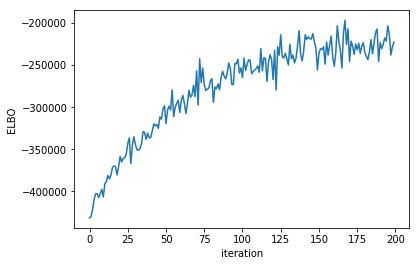

In [18]:
logger = run_adam(m, gpf.test_util.notebook_niter(2000))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO');

Iteration 0 -Likelihood: 7604646299.065756
Iteration 10 -Likelihood: 492133537.82898307
Iteration 20 -Likelihood: 230957035.38344944
Iteration 30 -Likelihood: 154855658.55731365
Iteration 40 -Likelihood: 120921268.62708369
Iteration 50 -Likelihood: 101955279.61501391
Iteration 60 -Likelihood: 89999577.2519541
Iteration 70 -Likelihood: 80406731.89526471
Iteration 80 -Likelihood: 72976919.88234597
Iteration 90 -Likelihood: 67112502.8225801
Iteration 100 -Likelihood: 61735273.30652521
Iteration 110 -Likelihood: 57197437.633981995
Iteration 120 -Likelihood: 53144010.35209016
Iteration 130 -Likelihood: 49505386.82308758
Iteration 140 -Likelihood: 46340695.291139044
Iteration 150 -Likelihood: 43571746.174732395
Iteration 160 -Likelihood: 40952485.40552382
Iteration 170 -Likelihood: 38649931.68741358
Iteration 180 -Likelihood: 36415981.066042565
Iteration 190 -Likelihood: 34525654.40246689


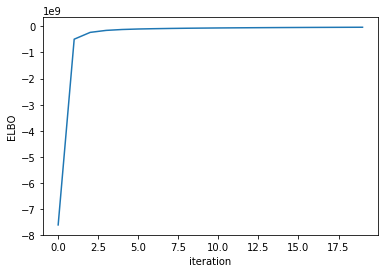

In [48]:
logger = run_adam(m, gpf.test_util.notebook_niter(200))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO');

Iteration 0 -Likelihood: 57055599646.10222
Iteration 10 -Likelihood: 7857316246.157918
Iteration 20 -Likelihood: 3039689790.383281
Iteration 30 -Likelihood: 949252718.3813705
Iteration 40 -Likelihood: 612525209.7442998
Iteration 50 -Likelihood: 426083192.40345716
Iteration 60 -Likelihood: 361729262.4038894
Iteration 70 -Likelihood: 327848516.7515662
Iteration 80 -Likelihood: 304156487.2869207
Iteration 90 -Likelihood: 291067104.0539652
Iteration 100 -Likelihood: 277351204.0561661
Iteration 110 -Likelihood: 265772076.39679882
Iteration 120 -Likelihood: 254799360.12433052
Iteration 130 -Likelihood: 243773566.9595441
Iteration 140 -Likelihood: 233972434.1137157
Iteration 150 -Likelihood: 225069485.60525715
Iteration 160 -Likelihood: 215885894.472939
Iteration 170 -Likelihood: 207495212.09358364
Iteration 180 -Likelihood: 198820224.899781
Iteration 190 -Likelihood: 191530627.5563605


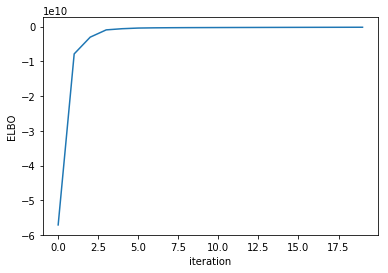

In [37]:
logger = run_adam(m, gpf.test_util.notebook_niter(200))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO');

Iteration 0 -Likelihood: 1116250.573691209
Iteration 10 -Likelihood: 959118.0576404427
Iteration 20 -Likelihood: 856462.4691196523
Iteration 30 -Likelihood: 718427.7164166907
Iteration 40 -Likelihood: 516321.10334951564
Iteration 50 -Likelihood: 313977.41016222275
Iteration 60 -Likelihood: 229301.93686466437
Iteration 70 -Likelihood: 191520.3277278901
Iteration 80 -Likelihood: 178323.06340459135
Iteration 90 -Likelihood: 171459.554599909
Iteration 100 -Likelihood: 166398.0236343173
Iteration 110 -Likelihood: 165893.14974940429
Iteration 120 -Likelihood: 165535.51406816355
Iteration 130 -Likelihood: 163207.9475844181
Iteration 140 -Likelihood: 160855.47004363252
Iteration 150 -Likelihood: 163968.9756829528
Iteration 160 -Likelihood: 159414.02693986203
Iteration 170 -Likelihood: 160904.37582217125
Iteration 180 -Likelihood: 160742.14598306673
Iteration 190 -Likelihood: 159409.26080105116


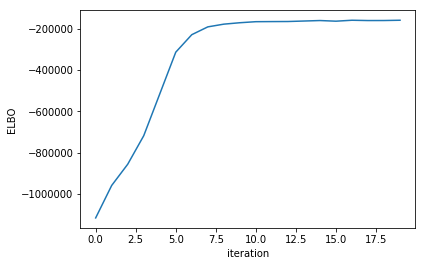

In [23]:
logger = run_adam(m, gpf.test_util.notebook_niter(200))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO');

## Score

In [18]:
predictions = m.predict_y(test_data_bin)

In [21]:
predictions = m.predict_f(test_data_bin)

X (500, 784)
X2 (500, 784)
Kernel (500, 500)
Norm x (500, 1)
Norm y (1, 500)
(500, 500)
X (500, 784)
X2 (?, ?)
Kernel (500, ?)
Norm x (500, 1)
Norm y (1, ?)
(500, ?)


In [49]:
?? m.predict_f

Signature:  m.predict_f(Xnew)
Source:   
    @autoflow((settings.float_type, [None, None]))
    def predict_f(self, Xnew):
        """
        Compute the mean and variance of the latent function(s) at the points
        Xnew.
        """
        return self._build_predict(Xnew)
File:      ~/.local/lib/python3.5/site-packages/gpflow/models/model.py
Type:      method


In [38]:
predictions[0].shape

(10000, 10)

In [19]:
test_score = np.sum(np.equal(np.argmax(predictions[0], 1), np.argmax(test_labels_bin, 1))) / len(test_data) * 100

In [20]:
test_score

61.77

In [63]:
m.compute_log_likelihood()

-486207.5589229643

In [19]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),True,"(500, 784)",True,"[[0.0009116464275071682, -0.12002359660102171,..."
SVGP/kern/dummy,Parameter,None,+ve,True,(),True,1.0000000002225007e-06
SVGP/kern/poly_kernel/variance,Parameter,None,+ve,False,(),True,1.0
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.0007149574263396e-06
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,0.12010764059879336
SVGP/q_mu,Parameter,None,(none),True,"(500, 10)",True,"[[-2.2493099253693796, -1.9904663729093899, -2..."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(10, 500, 500)",True,"[[[0.10860809687630675, 0.0, 0.0, 0.0, 0.0, 0...."


In [29]:
# test score
variance = 0.001
alpha = 10

m.kern.variance = 0.0018913713117732164
m.likelihood.variance = 5.61412412417899

print(m.compute_log_likelihood())

-30995651.903306656


In [53]:
# test score
variance = 0.001
alpha = 10

m.kern.variance = variance
m.likelihood.variance = alpha

print(m.compute_log_likelihood())

-1349785.1100260287


In [42]:
lengthscale = m.as_pandas_table().loc['SVGP/kern/lengthscales']['value']
variance = m.as_pandas_table().loc['SVGP/kern/variance']['value']
noise = m.as_pandas_table().loc['SVGP/likelihood/variance']['value']

KeyError: 'the label [SVGP/kern/lengthscales] is not in the [index]'

In [47]:
print(lengthscale)

8.16129484405451


In [48]:
print(variance)

0.025693371349520586


In [49]:
print(noise)

0.09286533248745456


## Verify using random features

In [39]:
from sklearn.linear_model import RidgeClassifier
from random_features import project_big_np_matrix
import torch

In [36]:
data = np.vstack([train_data_bin[:N], test_data_bin])

In [41]:
proj_data, proj_time = project_big_np_matrix(
                            data, out_dim=10000,
                            chunk_size=5000, projection='rbf',
                            framework='pytorch', dtype=torch.FloatTensor,
                            cuda=False, log_lengthscale_init=np.log(lengthscale))

Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Processing chunk of size: torch.Size([5000, 784])
Total time elapsed (seconds): 17.265944242477417
Time per chunk (seconds): 1.2332817316055298


In [42]:
clf = RidgeClassifier(alpha=noise)

In [44]:
clf.fit(np.sqrt(variance) * proj_data[:N], train_labels[:N])

RidgeClassifier(alpha=array(0.09287), class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)

In [46]:
clf.score(np.sqrt(variance) * proj_data[N:], test_labels)

0.8845

In [ ]:
# => the hyperparameter fit seems to be good!

In [ ]:
# full kernel only gets 0.8766